In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

# configure display
pd.set_option('display.max_colwidth', 200)
plt.style.use('default')

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')
print(f"Dataset shape before cleaning: {df.shape}")

df = df.dropna(subset=['Context', 'Response'])
# df = df.drop_duplicates(subset=['Context']).drop_duplicates(subset=['Response'])
# NOTE: ok dropping duplicates actually went down from 3508 to 925...
# Keep duplicates for now since they might have different counselor responses

exact_dupes = df[df.duplicated(subset=['Context', 'Response'], keep=False)]
print(f"Exact duplicates: {len(exact_dupes)} ({len(exact_dupes)/len(df)*100:.1f}%)")

# context-only duplicates
context_dupes = df[df.duplicated(subset=['Context'], keep=False)]
print(f"Duplicate contexts: {len(context_dupes)} ({len(context_dupes)/len(df)*100:.1f}%)")

# TODO: In v2, analyze if duplicate contexts have meaningfully different responses
# TODO: choose another dataset to combine with for more unique interactions

print(f"Dataset shape after cleaning: {df.shape}")

# simple text preprocessing for now
df['Context_clean'] = df['Context'].str.strip()
df['Response_clean'] = df['Response'].str.strip()

Dataset shape before cleaning: (3512, 2)
Exact duplicates: 1501 (42.8%)
Duplicate contexts: 3272 (93.3%)
Dataset shape after cleaning: (3508, 2)


In [72]:
df.iloc[0]

Context           I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suici...
Response          If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you ...
Context_clean     I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suici...
Response_clean    If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you ...
Name: 0, dtype: object

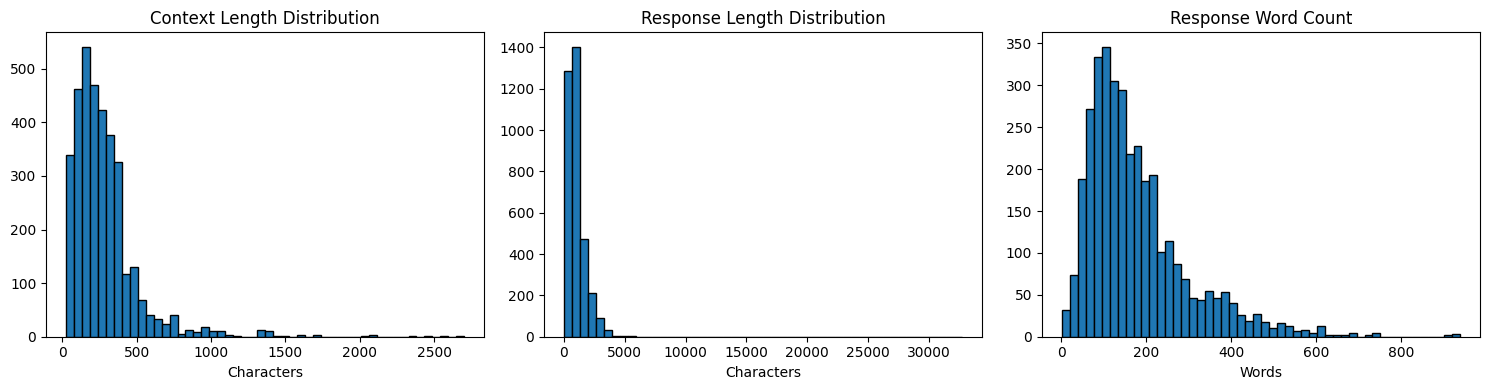

Average context length: 283 chars
Average response length: 1027 chars
Average response words: 177 words


In [73]:
df['context_length'] = df['Context'].str.len()
df['response_length'] = df['Response'].str.len()
df['response_words'] = df['Response'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['context_length'], bins=50, edgecolor='black')
axes[0].set_title('Context Length Distribution')
axes[0].set_xlabel('Characters')

axes[1].hist(df['response_length'], bins=50, edgecolor='black')
axes[1].set_title('Response Length Distribution')
axes[1].set_xlabel('Characters')

axes[2].hist(df['response_words'], bins=50, edgecolor='black')
axes[2].set_title('Response Word Count')
axes[2].set_xlabel('Words')

plt.tight_layout()
plt.show()

print(f"Average context length: {df['context_length'].mean():.0f} chars")
print(f"Average response length: {df['response_length'].mean():.0f} chars")
print(f"Average response words: {df['response_words'].mean():.0f} words")

In [74]:
# test embedding quality with more relevant queries
model = SentenceTransformer('all-MiniLM-L6-v2')

test_queries = [
    "I'm feeling anxious about my job",
    "I'm struggling with depression",
]

# encode all contexts once
print("Encoding all contexts...")
all_embeddings = model.encode(df['Context_clean'].tolist(), show_progress_bar=True)

# test each query
for query in test_queries:
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, all_embeddings)[0]
    
    # get top 3 matches
    top_indices = np.argsort(similarities)[-3:][::-1]
    
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}")
    
    for idx in top_indices:
        print(f"\nSimilarity {similarities[idx]:.3f}:")
        print(f"Context: {df.iloc[idx]['Context_clean'][:150]}...")
        print(f"Response preview: {df.iloc[idx]['Response_clean'][:100]}...")

Encoding all contexts...


Batches:   0%|          | 0/110 [00:00<?, ?it/s]


Query: I'm feeling anxious about my job

Similarity 0.575:
Context: I keep feeling paralyzed and unsure during interviews. Previous jobs have fired me for lack of performance, and five employers have rejected me after ...
Response preview: It sounds like you are feeling pretty overwhelmed and stuck between wanting to improve your work sit...

Similarity 0.575:
Context: I keep feeling paralyzed and unsure during interviews. Previous jobs have fired me for lack of performance, and five employers have rejected me after ...
Response preview: It sounds like you are feeling pretty overwhelmed and stuck between wanting to improve your work sit...

Similarity 0.562:
Context: I just took a job that requires me to travel far away from home. My family and I really need this job.

People keep telling me I have "anxiety" and ...
Response preview: Anxiety often occurs when big or unexpected changes come to our lives, like having new jobs, relocat...

Query: I'm struggling with depression

Similarit

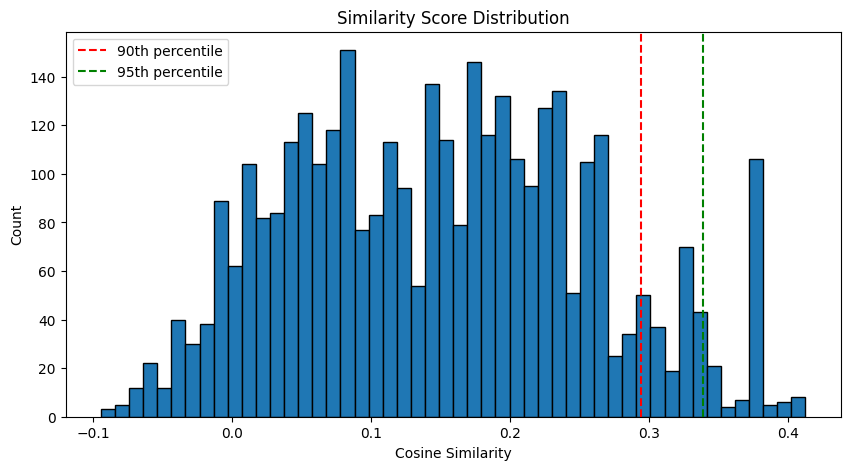

Similarity statistics:
Mean: 0.150
90th percentile: 0.294
95th percentile: 0.339
99th percentile: 0.381


In [75]:
# check similarity score distribution to set thresholds
test_embedding = model.encode(["general mental health concern"])
all_similarities = cosine_similarity(test_embedding, all_embeddings)[0]

plt.figure(figsize=(10, 5))
plt.hist(all_similarities, bins=50, edgecolor='black')
plt.axvline(np.percentile(all_similarities, 90), color='r', linestyle='--', label='90th percentile')
plt.axvline(np.percentile(all_similarities, 95), color='g', linestyle='--', label='95th percentile')
plt.title('Similarity Score Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.legend()
plt.show()

print(f"Similarity statistics:")
print(f"Mean: {all_similarities.mean():.3f}")
print(f"90th percentile: {np.percentile(all_similarities, 90):.3f}")
print(f"95th percentile: {np.percentile(all_similarities, 95):.3f}")
print(f"99th percentile: {np.percentile(all_similarities, 99):.3f}")

In [76]:
# determine minimum useful similarity threshold
threshold_analysis = []
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5]:
    matches = (all_similarities > threshold).sum()
    threshold_analysis.append((threshold, matches, matches/len(df)*100))

print("Similarity threshold analysis:")
for t, count, pct in threshold_analysis:
    print(f"Threshold {t}: {count} matches ({pct:.1f}%)")

# DECISION: Set minimum similarity to 0.4 to ensure relevant matches
MIN_SIMILARITY = 0.4

Similarity threshold analysis:
Threshold 0.3: 326 matches (9.3%)
Threshold 0.35: 136 matches (3.9%)
Threshold 0.4: 8 matches (0.2%)
Threshold 0.45: 0 matches (0.0%)
Threshold 0.5: 0 matches (0.0%)


In [77]:
from sklearn.cluster import KMeans

# subsample for speed
n_samples = 1000
sample_indices = np.random.choice(len(df), n_samples, replace=False)
sample_embeddings = all_embeddings[sample_indices]

# cluster
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sample_embeddings)

# analyze clusters
for i in range(n_clusters):
    cluster_indices = sample_indices[cluster_labels == i]
    print(f"\n{'='*60}")
    print(f"Cluster {i} ({len(cluster_indices)} conversations):")
    print(f"{'='*60}")
    
    # show 3 examples from this cluster
    for j in range(min(3, len(cluster_indices))):
        idx = cluster_indices[j]
        print(f"\nExample {j+1}:")
        print(f"Context: {df.iloc[idx]['Context_clean'][:100]}...")



Cluster 0 (84 conversations):

Example 1:
Context: I try to do everything right just so we won't argue, and it doesn't help the only time he is calm is...

Example 2:
Context: Nothing we've tried has worked so far....

Example 3:
Context: I keep on begging him to come back. I am so unhappy with him but am so scared of being a single pare...

Cluster 1 (141 conversations):

Example 1:
Context: Sometimes, when I look at my pet cat, I think about how innocent he is and how somebody could hurt o...

Example 2:
Context: I think I'm annoying and bothersome, but my girlfriend says I'm just fine. I don't think so, I think...

Example 3:
Context: My fiancée is always letting me know how I am a horrible/evil person, or I just don’t care enough wh...

Cluster 2 (207 conversations):

Example 1:
Context: I just need to know if I'm really crazy or not....

Example 2:
Context: I've been like this ever since I was in school; back then I transferred to another school. Now I'm t...

Example 3:
Context:

In [78]:
# analyze counselor response patterns
response_lengths = df['Response_clean'].str.len()
response_words = df['Response_clean'].str.split().str.len()

# identify response types by keywords
df['has_question'] = df['Response_clean'].str.contains(r'\?', regex=True)
df['has_validation'] = df['Response_clean'].str.lower().str.contains(
    r'understand|valid|normal|common|difficult|hard|challenging', regex=True
)
df['has_advice'] = df['Response_clean'].str.lower().str.contains(
    r'try|consider|might help|suggest|recommend|could', regex=True
)

print("Response characteristics:")
print(f"Contains question: {df['has_question'].sum()} ({df['has_question'].mean():.1%})")
print(f"Contains validation: {df['has_validation'].sum()} ({df['has_validation'].mean():.1%})")
print(f"Contains advice: {df['has_advice'].sum()} ({df['has_advice'].mean():.1%})")

Response characteristics:
Contains question: 1288 (36.7%)
Contains validation: 1669 (47.6%)
Contains advice: 1914 (54.6%)


In [79]:
# Analyze best practices in responses
df['response_quality_score'] = (
    df['has_question'].astype(int) + 
    df['has_validation'].astype(int) + 
    df['has_advice'].astype(int)
)

print(f"\nResponse quality distribution:")
print(df['response_quality_score'].value_counts().sort_index())

# Find exemplar responses
best_responses = df[df['response_quality_score'] == 3].sample(3)
print("\nExemplar responses (has all 3 elements):")
for idx, row in best_responses.iterrows():
    print(f"\nContext: {row['Context'][:100]}...")
    print(f"Response: {row['Response'][:200]}...")


Response quality distribution:
response_quality_score
0     646
1    1291
2    1133
3     438
Name: count, dtype: int64

Exemplar responses (has all 3 elements):

Context: Sometimes I can't stop thinking about life after death. I was raised in a religion that teaches that...
Response: Religious questioning is a complex and often philosophical topic, and these types of questions, especially around heaven, hell, and an afterlife can bring up a host of difficult & confusing feelings. ...

Context: I have PTSD. The side effects are really bad and have impacts on sex, anger and my relationships.  I...
Response: Hi there, I hear you, PTSD has a very debilitating effect on your whole life. I know that from personal experience. Recovering from it is possible and doable! First is step is to acknowledge to yourse...

Context: I have no self control over food. Most people stop when they've had enough, but I keep eating for th...
Response: Hello! I'm so glad you decided to write in today. This is

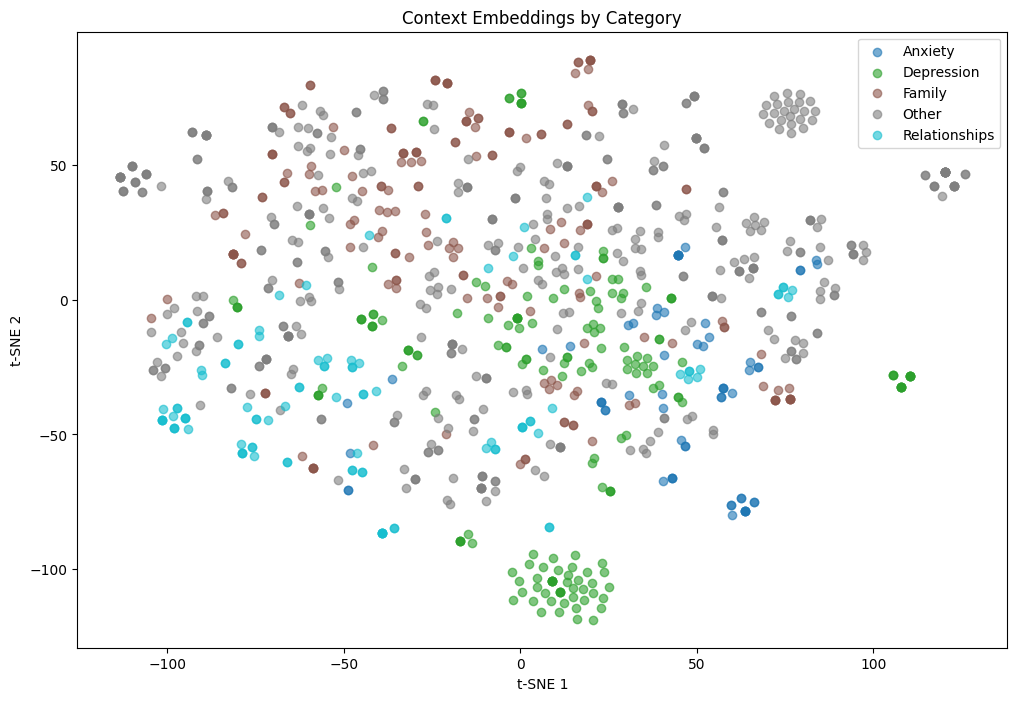

In [80]:
# visualize with categories
from sklearn.decomposition import PCA

# use PCA for faster computation
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(all_embeddings)

# then t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca[:1000])  # subsample

# create categories based on context keywords
df['category'] = 'Other'
df.loc[df['Context_clean'].str.lower().str.contains('anxiety|anxious|worry'), 'category'] = 'Anxiety'
df.loc[df['Context_clean'].str.lower().str.contains('depress|sad|hopeless'), 'category'] = 'Depression'
df.loc[df['Context_clean'].str.lower().str.contains('relationship|partner|spouse'), 'category'] = 'Relationships'
df.loc[df['Context_clean'].str.lower().str.contains('family|parent|child'), 'category'] = 'Family'

# plot
plt.figure(figsize=(12, 8))
categories = df.iloc[:1000]['category'].values
unique_categories = np.unique(categories)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))

for i, cat in enumerate(unique_categories):
    mask = categories == cat
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=[colors[i]], label=cat, alpha=0.6)

plt.title('Context Embeddings by Category')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [81]:
# test query speed
import time

# single query
start = time.time()
query_emb = model.encode(["test query"])
sims = cosine_similarity(query_emb, all_embeddings)[0]
top_k = np.argsort(sims)[-3:][::-1]
single_time = time.time() - start

print(f"Single query time: {single_time*1000:.1f}ms")
print(f"Projected queries per second: {1/single_time:.1f}")

# batch queries
batch_size = 10
start = time.time()
batch_queries = ["test query"] * batch_size
batch_emb = model.encode(batch_queries)
batch_sims = cosine_similarity(batch_emb, all_embeddings)
batch_time = time.time() - start

print(f"\nBatch {batch_size} queries time: {batch_time*1000:.1f}ms")
print(f"Per query in batch: {batch_time/batch_size*1000:.1f}ms")

# TODO: implement FAISS for better performance at scale
# TODO: add caching for common queries

Single query time: 23.0ms
Projected queries per second: 43.5

Batch 10 queries time: 39.0ms
Per query in batch: 3.9ms


In [82]:
# Add edge case testing
edge_queries = [
    "",  # empty
    "help",  # too short
    "I need help" * 100,  # too long
    "私は悲しいです",  # non-English
    "AAAAAAAAA" * 20,  # nonsense
]

print("Edge case handling:")
for query in edge_queries[:3]:  # test first 3
    try:
        if len(query) > 50:
            query_display = query[:50] + "..."
        else:
            query_display = query if query else "[empty]"
            
        emb = model.encode([query])
        sims = cosine_similarity(emb, all_embeddings)[0]
        max_sim = sims.max()
        print(f"Query: {query_display} -> Max similarity: {max_sim:.3f}")
    except Exception as e:
        print(f"Query: {query_display} -> Error: {e}")

Edge case handling:
Query: [empty] -> Max similarity: 0.240
Query: help -> Max similarity: 0.287
Query: I need helpI need helpI need helpI need helpI need... -> Max similarity: 0.258


In [83]:
# Save all processed data and metadata
from sklearn.cluster import KMeans

# Generate cluster labels for all data
print("Generating cluster labels for all data...")
kmeans = KMeans(n_clusters=10, random_state=42)
all_clusters = kmeans.fit_predict(all_embeddings)

# Calculate response quality scores
df['response_quality_score'] = (
    df['has_question'].astype(int) + 
    df['has_validation'].astype(int) + 
    df['has_advice'].astype(int)
)

# Create processed dataframe with all features
processed_df = df[['Context_clean', 'Response_clean', 'category', 
                   'has_question', 'has_validation', 'has_advice']].copy()
processed_df.columns = ['Context', 'Response', 'category', 
                        'has_question', 'has_validation', 'has_advice']

# Add new features
processed_df['cluster'] = all_clusters
processed_df['response_quality_score'] = df['response_quality_score']

# Save processed conversations
processed_df.to_csv('processed_conversations.csv', index=False)
print(f"Saved {len(processed_df)} processed conversations with all features")

# Save embeddings
np.save('embeddings.npy', all_embeddings)
print(f"Saved embeddings with shape {all_embeddings.shape}")

# Save cluster centers for new query classification
np.save('cluster_centers.npy', kmeans.cluster_centers_)
print(f"Saved cluster centers with shape {kmeans.cluster_centers_.shape}")

# Save metadata for app configuration
metadata = {
    'min_similarity_threshold': 0.3,  # Based on threshold analysis
    'total_conversations': len(df),
    'embedding_dim': all_embeddings.shape[1],
    'n_clusters': 10,
    'categories': df['category'].value_counts().to_dict(),
    'avg_response_length': df['response_length'].mean(),
    'response_quality_distribution': df['response_quality_score'].value_counts().to_dict()
}

import json
with open('metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("Saved metadata.json")

print("\nFiles created:")
print("- processed_conversations.csv")
print("- embeddings.npy") 
print("- cluster_centers.npy")
print("- metadata.json")

Generating cluster labels for all data...
Saved 3508 processed conversations with all features
Saved embeddings with shape (3508, 384)
Saved cluster centers with shape (10, 384)
Saved metadata.json

Files created:
- processed_conversations.csv
- embeddings.npy
- cluster_centers.npy
- metadata.json
